## Check if all ~300k original sequences can be detected using full index and GPT code

In [1]:
# # ChatGPT code
# cfcode = {
#     'L': "GGG",
#     'S': "TTC",
#     'D': "CTA",
#     'G': "GCT",
#     'A': "TCG",
#     'V': "AGC",
#     'I': "GTG",
#     'T': "GAC",
#     'F': "TAG",
#     'R': "ATG",
#     'E': "CGA",
#     'N': "GTA",
#     'Y': "TAC",
#     'K': "CAT",
#     'M': "CAG",
#     'P': "AGT",
#     'Q': "TGA",
#     'C': "CGT",
#     'H': "GCA",
#     'W': "ACT",
#     "X": "NNN",  # Amino acid not known
#     "B": "CTA",  # Represents either N or D - will translate as D here (N is only off by one base)
#     "J": "GGG",  # Represents either L or I - will translate as L here (I is only off by one base)
#     "Z": "CGA"   # Represents either E or Q - will translate as E here (Q is only off by one base)
# }

In [2]:
# from Bio import SeqIO

# palmdb = "/home/laura/projects/virus-watch-data/virus_ref/uniques.fa"
# revtrans_gptcode = "/home/laura/projects/virus-watch-data/virus_ref/revtrans_gptcode.fa"

# with open(revtrans_gptcode, "w") as new_code_fasta:
#     for record in SeqIO.parse(palmdb, "fasta"):
#         # Translate AA sequence to comma-free
#         cfc_seq_temp = []
#         for aa in record.seq:
#             # Capitalize amino acid
#             aa = aa.capitalize()

#             # Rev translate to comme-free code
#             cfc_seq_temp.append(cfcode[aa])
        
#         new_code_fasta.write(">" + record.id + "\n")
#         new_code_fasta.write("".join(cfc_seq_temp) + "\n")

___

# !!! Switch to GPT code kallisto

In [3]:
palmdb = "/home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa"
virus_t2g = "/home/laura/projects/virus-watch-data/virus_ref/nodup_clu_t2g.txt"

virus_index = "/home/laura/projects/virus-watch-data/virus_ref/testing/index_gpt.idx"
out_folder = "/home/laura/projects/virus-watch-data/virus_ref/testing"
palmdb_nn_fasta = "/home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn.fasta"
sample = "all_vs_all_gptcode"

bustools = "/home/laura/projects/bustools/build/src/bustools"

In [14]:
# Generate virus reference index
!/usr/bin/time -v /home/laura/bin/usr/local/bin/kallisto index \
    -t 32 \
    --aa \
    -i $virus_index \
    $palmdb


[build] loading fasta file /home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37979823
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7965971
CompactedDBG::filter(): Processed 87630084 k-mers in 296561 reads
CompactedDBG::filter(): Found 37889984 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 259629
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 1961563 uni

In [15]:
!/usr/bin/time -v /home/laura/bin/usr/local/bin/kallisto bus \
        -i $virus_index \
        -o $out_folder/$sample \
        --aa \
        -t 32 \
        $palmdb_nn_fasta \
        &> $out_folder/$sample/kb_out.txt

!$bustools sort -o $out_folder/$sample/output_sorted.bus $out_folder/$sample/output.bus

!$bustools count \
    --genecounts \
    --cm -m \
    -o $out_folder/$sample/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/$sample/matrix.ec \
    -t $out_folder/$sample/transcripts.txt \
    $out_folder/$sample/output_sorted.bus

 all fits in buffer
Read in 182 BUS records
reading time 0s
sorting time 0s
writing time 0s


In [4]:
# Load count matrix
import kb_python.utils as kb_utils

# Filepath to counts
X = f"{out_folder}/{sample}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/{sample}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/{sample}/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 99228

In [5]:
# Load number of expected matches per representative sequence
import pandas as pd

u_tax = f"/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"
# Load representative IDs and their members
rep_id_df = pd.read_csv(u_tax)
rep_id_df

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [6]:
%%time
counts = []
expected_counts = []
for virus_id in adata.var.index:
    counts.append(adata[:, adata.var.index==virus_id].X.sum())
    expected_counts.append(len(rep_id_df[rep_id_df["rep_ID"]==virus_id]))

CPU times: user 28min 56s, sys: 446 ms, total: 28min 56s
Wall time: 28min 56s


In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

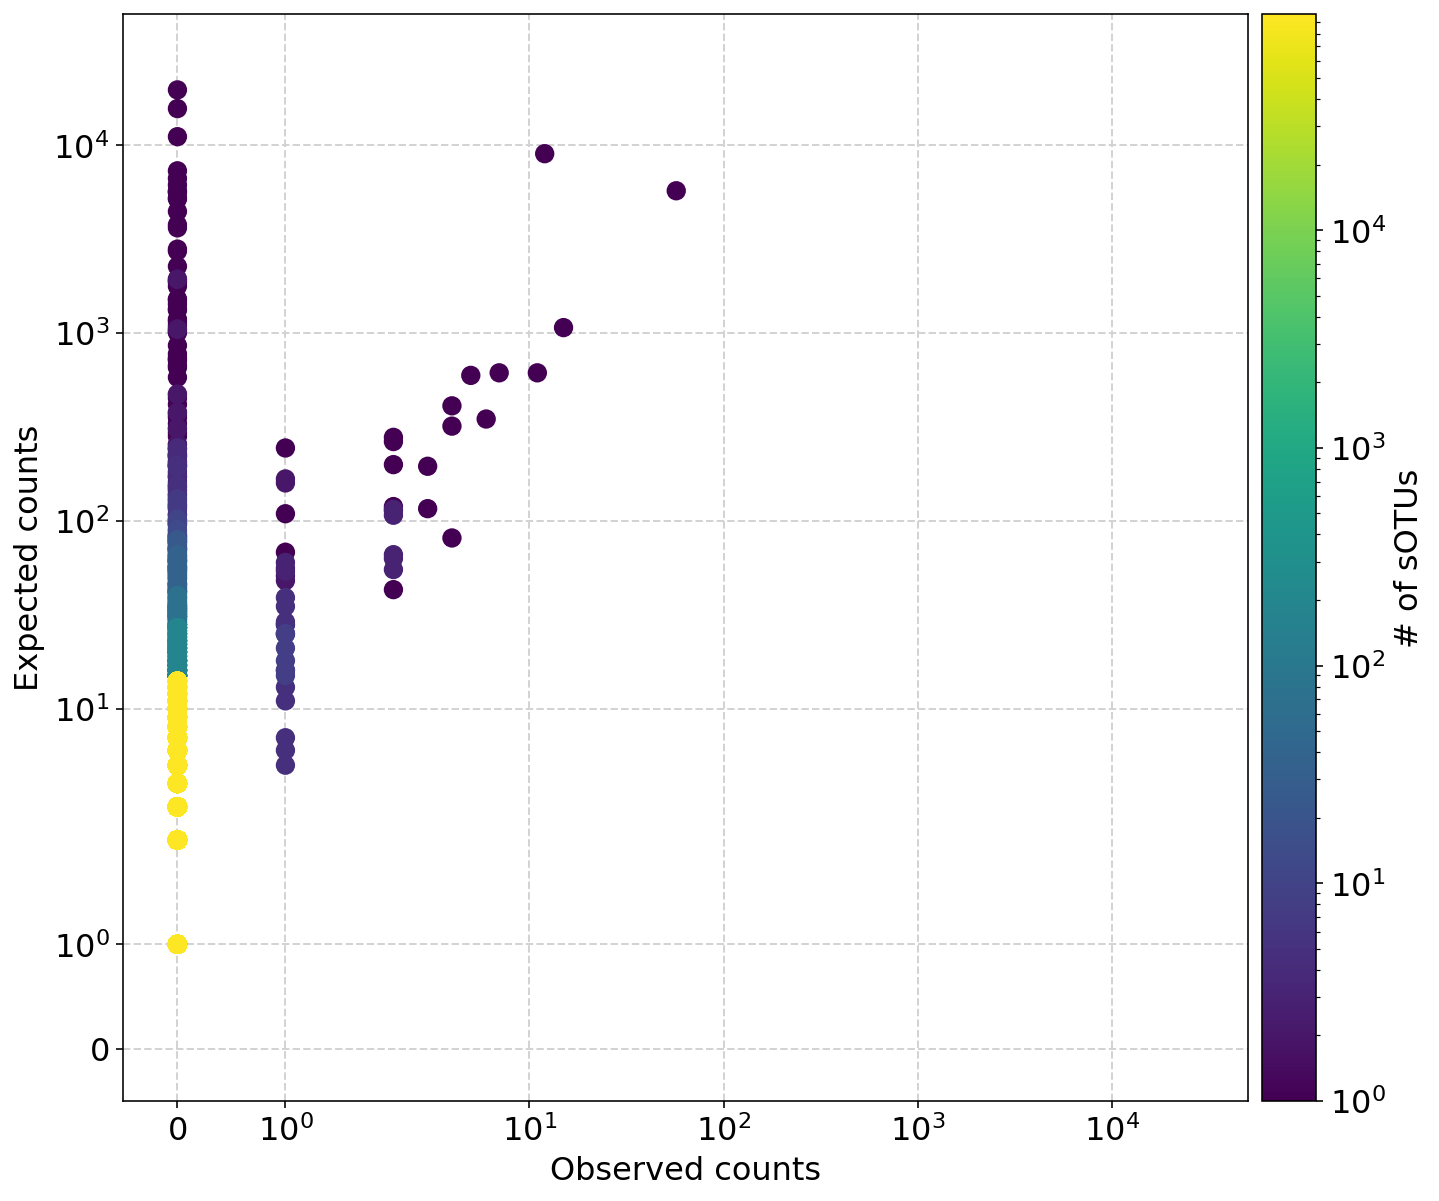

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
fontsize = 16

x = np.array(counts)
y = np.array(expected_counts)

# Histogram data to show point density
bins = [1500, 1500]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
        
scatter = ax.scatter(x2, y2, c=z2, cmap="viridis", norm=matplotlib.colors.LogNorm(), s=75)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
cbar.ax.tick_params(axis="both", labelsize=fontsize)
cbar.ax.set_ylabel(f"# of sOTUs", fontsize=fontsize)

ax.set_ylim(bottom=-0.5, top=50000)
ax.set_xlim(left=-0.5, right=50000)

ax.set_yscale("symlog")
ax.set_xscale("symlog")

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_ylabel("Expected counts", fontsize=fontsize)
ax.set_xlabel("Observed counts", fontsize=fontsize)

plt.savefig(f"figures/3.4_{sample}.png", dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format='retina'

# fig, ax = plt.subplots(figsize=(10,10))
# fontsize = 14

# # Plot how often each sequence in ref was seen
# unique, counts = np.unique(np.array(adata.X.todense())[0], return_counts=True)
# ax.bar(unique, counts)
# ax.set_xlabel("Observed count for one ID", fontsize=fontsize)
# ax.set_ylabel("Number of occurences", fontsize=fontsize)
# ax.set_yscale("symlog")
# ax.set_xticks(np.arange(unique.max()+1).astype(int))

# # # Match x lim to GPT code
# # ax.set_xlim(left=0, right=17)

# ax.margins(x=0.1)
# ax.tick_params(axis="both", labelsize=fontsize)

# plt.savefig(f"figures/3.4_{sample}_symlog.png", dpi=300, bbox_inches="tight")

# fig.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format='retina'

# fig, ax = plt.subplots(figsize=(7,7))
# # Plot how often each sequence in ref was seen
# unique, counts = np.unique(np.array(adata.X.todense())[0], return_counts=True)
# ax.bar(unique, counts)
# ax.set_xlabel("Observed count for one ID")
# ax.set_ylabel("Number of occurences")
# ax.set_xticks(np.arange(unique.max()+1).astype(int))

# ax.axhline(296623, c="black", ls="--", lw=1)

# plt.savefig(f"figures/3.4_{sample}.png", dpi=300, bbox_inches="tight")

# fig.show()